In [ ]:
! nvidia-smi

In [4]:
import sys
sys.path.append('/content/drive/MyDrive/Colab-Notebooks/grad-ass')

import pandas as pd
import numpy as np

from common import common, BBoxVisualizer

import os
import json

from PIL import Image
import cv2
from matplotlib import pyplot as plt

In [5]:
MODEL_SRC = common['MODEL_SRC']
DATA_SRC = common['DATA_SRC']

In [6]:
images = pd.read_csv(os.path.join(DATA_SRC, 'images.csv'))
annotations = pd.read_csv(os.path.join(DATA_SRC, 'annotations.csv'))
categories = pd.read_csv(os.path.join(DATA_SRC, 'categories.csv'))

In [7]:
def im_show(img_path, scaler):
    with Image.open(img_path) as im:
        im = im.resize((int(im.size[0] * scaler), int(im.size[1] * scaler)), Image.ANTIALIAS)
        display(im)

Open ```cfg/yolov4_custom.cfg``` and change the ```witdth``` and ```height``` bigger for better score.

### predict an image

In [ ]:
os.chdir(os.path.join(MODEL_SRC, 'darknet'))
! chmod +x ./darknet
! ./darknet detector test data/classes.data cfg/yolov4-custom.cfg backup/yolov4-custom_8100.weights data/real/real_6.png

ground truth


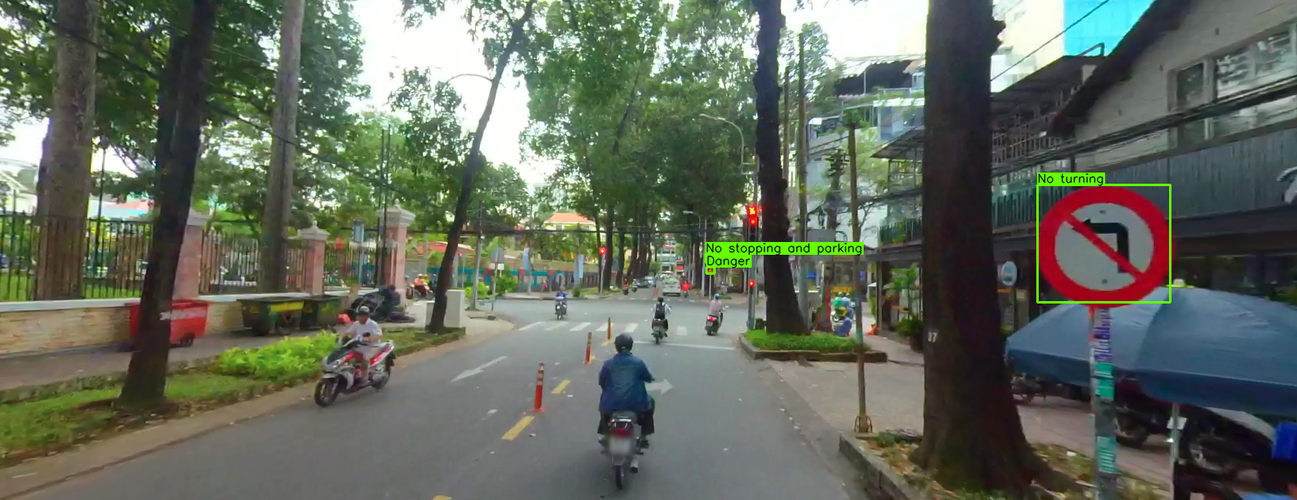

prediction


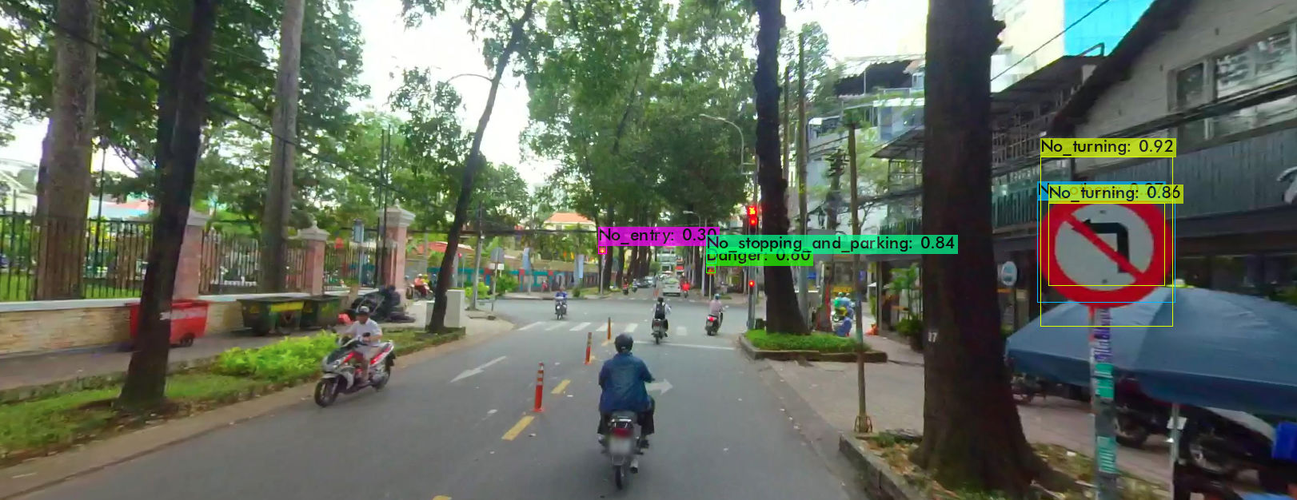

In [124]:
image_id = 5609

#ground truth
print("ground truth")
bbox_visualizer = BBoxVisualizer(
    box_color=(100, 255, 0),
    text_color=(0, 0, 0)
)

image = images[images['id'] == image_id]
annot = annotations[annotations['image_id'] == image['id'].values[0]]

img = cv2.imread(os.path.join(DATA_SRC, 'images', image['file_name'].values[0]))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
bbox_img = bbox_visualizer.visualize(
    img,
    [json.loads(bbox) for bbox in annot['bbox'].values],
    [categories[categories['id'] == label_id]['supercategory_eng'].values[0] for label_id in annot['category_id'].values],
    image['file_name'],
    'coco',
    'cv2',
    plt_show=False
)

bbox_img = Image.fromarray(bbox_img)
bbox_img = bbox_img.resize((int(bbox_img.size[0] * 0.8), int(bbox_img.size[1] * 0.8)), Image.ANTIALIAS)
display(bbox_img)

#prediction
print("prediction")
im_show(os.path.join(MODEL_SRC, 'darknet', 'predictions.jpg'), 0.8)

### test a list of images and create bbox annotations file

In [ ]:
os.chdir(os.path.join(MODEL_SRC, 'darknet'))
! chmod +x ./darknet
! ./darknet detector test data/classes.data cfg/yolov4-custom.cfg backup/yolov4-custom_8100.weights -ext_output -dont_show -out result.json < data/valid.txt

### video prediction

In [ ]:
os.chdir(os.path.join(MODEL_SRC, 'darknet'))
! chmod +x ./darknet
! ./darknet detector demo data/classes.data cfg/yolov4-custom.cfg backup/yolov4-custom_8100.weights data/test.mp4 -out_filename res.avi

### calculate mAP

In [ ]:
os.chdir(os.path.join(MODEL_SRC, 'darknet'))
! chmod +x ./darknet
! ./darknet detector map data/classes.data cfg/yolov4-custom.cfg backup/yolov4-custom_8100.weights -iou_thresh 0.50 -point 11

No handles with labels found to put in legend.


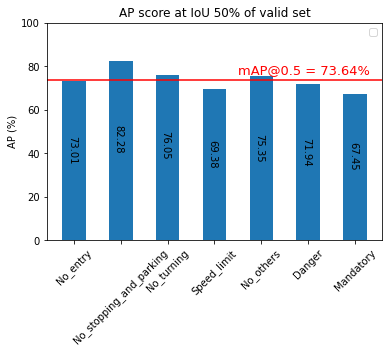

In [117]:
classes_label = ['No_entry', 'No_stopping_and_parking', 'No_turning', 'Speed_limit', 'No_others', 'Danger', 'Mandatory']
ap = [73.01, 82.28, 76.05, 69.38, 75.35, 71.94, 67.45]

% matplotlib inline
width = 0.5

b1 = plt.bar(
    classes_label,
    ap,
    width
)

for i in range(0, len(classes_label)):
    plt.text(
        i - 0.15, #go to xtick
        ap[i] // 2, #go to the top, then divide by 2 -> go to center
        ap[i],
        rotation=-90
    )

plt.xticks(rotation=45)
plt.yticks(np.arange(0, 120, step=20))

plt.axhline(y=np.mean(ap), color='r', linestyle='-')
plt.text(4 - 0.5, np.mean(ap) + 3, 'mAP@0.5 = {}%'.format(np.round(np.mean(ap), 2)), color='r', fontsize=13)

plt.ylabel('AP (%)')
plt.title('AP score at IoU 50% of valid set')
plt.legend()

plt.show()

In [ ]:
iter = [15.0, 18.0, 27.0, 34.0, 39.0, 43.0, 48.0, 52.0, 54.0, 65.0, 68.0, 75.0, 81.0, 85.0, 87.0, 95.0, 102.0] 
map50 = [48.5, 50.93, 57.95, 63.13, 63.97, 65.64, 66.04, 65.71, 65.7, 67.08, 65.92, 63.84, 68.78, 68.18, 65.14, 67.56, 68.40] #mAP@0.50

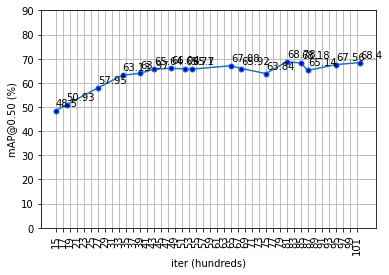

In [ ]:
plt.plot(iter, map50, marker='.', markersize=10, markerfacecolor='blue')
plt.xticks(range(int(min(iter)), int(max(iter)+1), 2), rotation=90)
plt.yticks(range(0, 100, 10))
plt.xlabel("iter (hundreds)")
plt.ylabel("mAP@0.50 (%)")
for map, i in zip(map50, iter):
    plt.annotate(map, xy = (i, map + 2.0))
plt.grid()
plt.show()